In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt


class Enviroment:
    def __init__(self, is_bernoulli, no_arms=10):
        self.no_arms = no_arms
        
        self.pull_arm = self.pull_arm_bernaulli if is_bernoulli else self.pull_arm_gaussion
            
        self.arms = {}
        for arm in range(self.no_arms):
            self.arms[arm] = np.random.rand()
        
    def update(self):
        for arm in range(self.no_arms):
            self.arms[arm] = np.random.rand()
        
    def pull_arm_bernaulli(self, arm):
        return 1 if self.arms[arm] > np.random.rand() else 0
    
    def pull_arm_gaussion(self, arm):
        return np.random.normal(self.arms[arm], scale=0.1)
    
        

In [2]:
class AgentUCB:
    def __init__(self, no_arms=10, alpha=0.01):
        self.alpha = alpha
        self.no_arms = no_arms
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['likely'] = 0
            self.info[arm]['no_visited'] = 0
            self.info[arm]['is_visited'] = False
            self.info[arm]['value'] = 0
        self.round = 0
        
    def pull(self):
        self.round += 1
        
        for arm in range(self.no_arms):
            if not self.info[arm]['is_visited']:
                self.info[arm]['is_visited'] = True
                self.info[arm]['no_visited'] += 1
                return arm
            
        arm = np.argmax(np.asarray([self.info[arm]['likely'] for arm in range(self.no_arms)]))
        self.info[arm]['no_visited'] += 1
        
        return arm
    
    def update(self, action, reward):
        
        self.info[action]['value'] += self.alpha*(reward-self.info[action]['value'])
        
        if all([self.info[arm]['is_visited'] for arm in range(self.no_arms)]):
            for arm in range(self.no_arms):
                self.info[arm]['likely'] = self.info[arm]['value'] + \
                np.sqrt((2*np.log(self.round))/self.info[arm]['no_visited'])
                
            
        

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable

import copy
import operator


class Model(torch.nn.Module):
    def __init__(self, num_inputs, action_space,settings={}):
        super(Model, self).__init__()

        #should hidden units have biases?
        _b = True

        num_outputs = action_space

        #overwritable defaults
        sz = 8  #how many neurons per layer
        hid_layers = 6 #how many hidden layers
        af = nn.ReLU 
        oaf = nn.Sigmoid
        

        afunc = {'relu':nn.ReLU,'tanh':nn.Tanh,'linear':lambda : linear,'sigmoid':nn.Sigmoid}
  
        self._af = af
        self.af = af()
        self.sigmoid = oaf()
        self.softmax = nn.Softmax(dim=0)

        #first fully-connected layer changing from input-size representation to hidden-size representation
        self.fc1 = nn.Linear(num_inputs, sz, bias=_b) 

        self.hidden_layers = []
        hid_layers = 2
        sz = 8

        #create all the hidden layers
        for x in range(hid_layers):
            self.hidden_layers.append(nn.Linear(sz, sz, bias=True))
            self.add_module("hl%d"%x,self.hidden_layers[-1])

        #create the hidden -> output layer
        self.fc_out = nn.Linear(sz, num_outputs, bias=_b)

        self.train()

    def forward(self, inputs, intermediate=None, debug=False):

        x = inputs
        #fully connection input -> hidden
        try:
            x = self.fc1(x.float())
        except:
            print(x.int())
            raise TypeError("x: ", x)
        x = self._af()(x)
        
        #propagate signal through hidden layers
        for idx,layer in enumerate(self.hidden_layers):

            #do fc computation
            x = layer(x)

            #run it through activation function
            x = self._af()(x)

            if intermediate == idx:
                cached = x
        
        #output layer
        x = self.fc_out(x)
        #softmax
        x = self.softmax(x)

        if intermediate!=None:
            return x,cached

        return x
    
    #function to grab current flattened neural network weights
    def extract_parameters(self):
        tot_size = self.count_parameters()
        pvec = np.zeros(tot_size, np.float32)
        count = 0
        for param in self.parameters():
            sz = param.data.numpy().flatten().shape[0]
            pvec[count:count + sz] = param.data.numpy().flatten()
            count += sz
        return pvec.copy()
    
    #function to inject a flat vector of ANN parameters into the model's current neural network weights
    def inject_parameters(self, pvec):
        tot_size = self.count_parameters()
        count = 0

        for param in self.parameters():
            sz = param.cpu().data.numpy().flatten().shape[0]
            raw = pvec[count:count + sz]
            reshaped = raw.reshape(param.cpu().data.numpy().shape)
            param.data = torch.from_numpy(reshaped).float()
            count += sz

        return pvec

    #count how many parameters are in the model
    def count_parameters(self):
        count = 0
        for param in self.parameters():
            #print param.data.numpy().shape
            count += param.cpu().data.numpy().flatten().shape[0]
        return count

class Individual:
    def __init__(self, no_arms=10, mag=0.1):
        self.no_arms = no_arms
        self.mag = mag
        self.net_rwd = 0
        self.model = Model(no_arms, no_arms)
        self.info = {}
        for arm in range(self.no_arms):
            self.info[arm] = {}
            self.info[arm]['no_visited'] = 0
            self.info[arm]['value'] = 0
        
    def pull(self):
        actions = self.model(Variable(torch.Tensor(np.array([self.info[arm]['no_visited'] for arm in range(self.no_arms)]))))
        try:
            arm = np.random.choice(self.no_arms, 1, p=actions.detach().numpy())[0]
        except:
            raise TypeError("check", actions)
        self.info[arm]['no_visited'] += 1
        return arm
    
    def mutate(self, mu, sigma=0.1, mag=None):
        if mag==None:
            mag = self.mag
        parameters = self.model.extract_parameters()
        pertubation = np.array([np.random.normal(loc=mean, scale=0.1) for mean in mu])
        updated_paramaters = pertubation
        child = Individual(self.no_arms, self.mag)
        child.model.inject_parameters(updated_paramaters.astype(float)) 
        return child
    
    def run(self, env, trails=20):
        for _ in range(trails):
            arm = self.pull()
            r = env.pull_arm(arm)
            self.net_rwd += r 
        self.fitness = self.net_rwd/trails
        self.net_rwd = 0
        
        


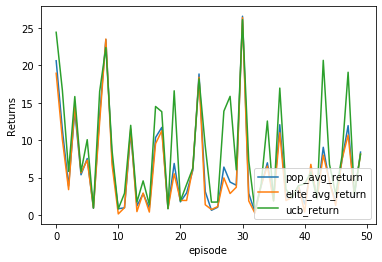

In [4]:
import random
from functools import reduce

# population size
psize = 25
#mutation magnitude
mag = 0.05
# number of generations
generations = 500
#number of arms
no_arms = 10

greedy_kill=5

#set of generations after which the enviroment is updated
mark = random.sample(range(generations), int(generations/10))

#setting the enviroment
env  = Enviroment(is_bernoulli=True, no_arms=no_arms)

#set of elite agent
elite = [None]*5
#counter
k=0
# Average rewards for ES
avg_elite_rwd = 0
avg_rwd = 0
rwds = []
elite_rwds = []

#setting UCB agent
ucb = AgentUCB(no_arms)

#Average reward of UCB agent
ucb_rwd = 0
ucb_rwds = []

#initilizing population
population = []
for _ in range(psize):
    population.append(Individual(no_arms))
    population[-1].run(env)

  
    
for gen in range(generations):
    
    k += 1
        
    if gen in mark:
        rwds.append(avg_rwd/(psize))
        elite_rwds.append(avg_elite_rwd/(len(elite)))
        
        ucb_rwd /= 20
        ucb_rwds.append(ucb_rwd/(psize))
        
        avg_rwd = 0
        avg_elite_rwd = 0
        ucb_rwd = 0
        k = 0
        env.update()
    
    for indv in population:
        avg_rwd += indv.fitness
        
    for _ in range(psize*20):
        act = ucb.pull()
        r = env.pull_arm(act)
        ucb.update(act, r)
        ucb_rwd += r        
    
    #Getting elite agent
    values = [[copy.deepcopy(ind), ind.fitness] for ind in population]
    values.sort(key = operator.itemgetter(1))
    for x in enumerate(values[-(1+len(elite)):-1]):
        elite[x[0]] =  x[1][0]
        
  #  print('pop fitness', np.mean([ind.fitness for ind in population]))
    #print('elite fitness', np.mean([ind.fitness for ind in elite]))
    
    [ind.run(env) for ind in population]
    
    # Finding mean parameters of elite agent
    mu = np.mean([ind.model.extract_parameters() for ind in elite], axis=0)
    
  #  print(mu)

    children = [ind.mutate(mu) for ind in population]
    [child.run(env) for child in children]
    
    #Killing
    all_individuals = population + children
    for _ in range(psize):
        to_kill = random.sample(all_individuals, greedy_kill)
        to_kill = reduce(lambda x, y: x if x.fitness < y.fitness else y, to_kill)
        all_individuals.remove(to_kill)
        
  #  print('test fitness', np.mean([ind.fitness for ind in population]))
  #  [ind.run(env) for ind in elite]
   # print('test_elite fitness', np.mean([ind.fitness for ind in elite]))

    for indv in elite:
        indv.run(env)
        avg_elite_rwd += indv.fitness
    population = all_individuals
'''
for agent in elite:
    print(agent.model(Variable(torch.Tensor(np.array([agent.info[arm]['no_visited'] for arm in range(no_arms)])))))
'''

plt.plot(range(len(rwds)), rwds)
plt.plot(range(len(rwds)), elite_rwds)
plt.plot(range(len(rwds)), ucb_rwds)


plt.ylabel('Returns')
plt.xlabel('episode') 
plt.legend(['pop_avg_return', 'elite_avg_return', 'ucb_return'], loc='lower right')
#plt.rcParams["figure.figsize"] = (10, 10)
plt.show()


In [5]:
data = np.array([[round(a, 2) ,round(b, 2) ,round(c, 2)] for a,b,c in zip(rwds, elite_rwds, ucb_rwds)])
teams_list = ['Pop return', 'elite_return', 'UCB return']
row_format ="{:>15}" * (len(teams_list) + 1)
print(row_format.format("", *teams_list))
for team, row in zip(sorted(mark), data):
    print(row_format.format(team, *row))
    

                    Pop return   elite_return     UCB return
             27          20.64          18.96          24.44
             44          11.43          10.08          16.67
             50           3.87           3.39           5.83
             67           13.9          14.58          15.84
             73           5.38           5.64           5.79
             84           7.55           7.33          10.07
             85           0.89           0.95           0.93
            105          13.29          12.43          16.53
            131          23.47          23.54           22.4
            140           7.48            6.7           8.58
            141           0.83           0.14           0.81
            144           0.96           0.97            2.9
            157          11.01           11.5          11.99
            159           1.21           0.45           1.73
            164           2.85           2.93           4.56
            166         